In [16]:
import torch
import torch.nn as nn
import numpy as np

import matplotlib.pyplot as plt
import sys
from tqdm import tqdm

from dataset import Dataset

class HingeLoss(nn.Module):
    def __init__(self,margin = 1):
        super(HingeLoss, self).__init__()
        self.margin = margin
    def forward(self, inputs, targets):
        #loss = -1 * (targets * torch.log(inputs) + (1 - targets) * torch.log(1 - inputs))
        loss = torch.max(torch.tensor(0.), self.margin - inputs * targets)
        return loss.mean()

In [17]:
class NonStandard(nn.Module):
    '''
        Implementazione modello visto con Fiaschi
    '''
    def __init__(self, input_size, output_size, hidden_size, margin = 1):
        super(NonStandard, self).__init__()
        self.ort_base = None

        # self.loss = HingeLoss(margin)
        self.loss = torch.nn.BCEWithLogitsLoss()
        
        self.W1 = torch.nn.Linear(input_size, hidden_size) 
        self.W2 = torch.nn.Linear(hidden_size, output_size)

        self.ReLU = torch.nn.ReLU()
        self.Sigmoid = torch.nn.Sigmoid()

        self.optimizer = torch.optim.SGD(self.parameters(), lr = 1e-5)
    
# --------------------------------------------

    def forward(self, x):
        k = self.W1(x)
        z = self.ReLU(k)
        y = self.W2(z)
        
        return y
        
    def train(self, dl):
        for x,y in dl:
            
            self.optimizer.zero_grad()
            
            y_pred_1 = self(x[y == 1])
            y_target_1 = y.unsqueeze(1)[y.unsqueeze(1) == 1]
            y_pred_1[y_pred_1 >= 0.99] = 1

            y_pred_2 = self(x[y == 0])
            y_target_2 = y.unsqueeze(1)[y.unsqueeze(1) == 0]
            y_pred_2[y_pred_2 <= -0.99] = 0

            eL1 = self.loss(y_pred_1.view(-1), y_target_1)
            eL1.backward(retain_graph = True)
            saved_grad = []

            for p in self.parameters():
                saved_grad.append(p.grad.clone().detach())
                
            # I want param.grad to contain only one gradient
            # self.optimizer.zero_grad()

            eL2 = self.loss(y_pred_2.view(-1), y_target_2)

            eL2.backward()

            for p_saved, p_new in zip(saved_grad, self.parameters()):
                # Il Bias lascio quello di L1
                if len(p_new.shape) == 1:
                    p_new.grad = p_saved
                else:
                    p_new.grad = self._project(p_new.grad, p_saved)

            self.optimizer.step()

        return eL1.detach().numpy(), eL2.detach().numpy()

    def _project(self, B, A):
        '''
            Project A on B
        '''
        proj = torch.zeros_like(A)
        
        for i in range(A.shape[0]):
            v = A[i]
            u = B[i]

            if torch.dot(u,u) != 0:
                proj[i] = (torch.dot(u, v) / torch.dot(u, u)) * u
            else:
                proj[i] = torch.zeros_like(v)
            
        return proj

In [18]:
torch.manual_seed(66)
modello = NonStandard(2,1,512)
ds = Dataset(16)
dl = ds.get_dataloader()

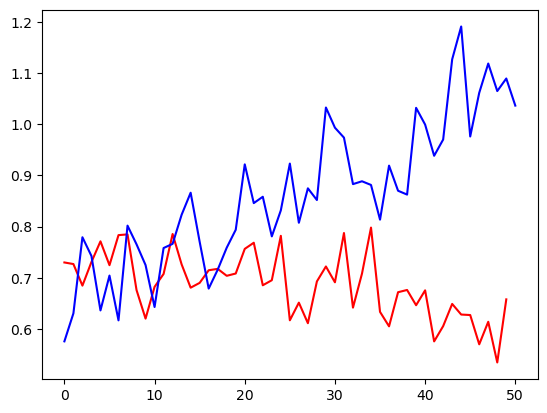

In [19]:
e1 = 1
err1 = []
err2 = []

while e1 > 1e-4:
# for i in tqdm(range(400)):
    e1, e2 = modello.train(dl) # Dentro dl ci deveno essere solo y == 1, ed usiamo BCEWithLogitsLoss
    err1.append(e1) 
    err2.append(e2)

plt.plot([x for x in range(len(err1))], err1, label = "Loss1", c = 'red')
plt.plot([x for x in range(len(err2))], err2, label = "Loss2", c = 'blue')
plt.show()

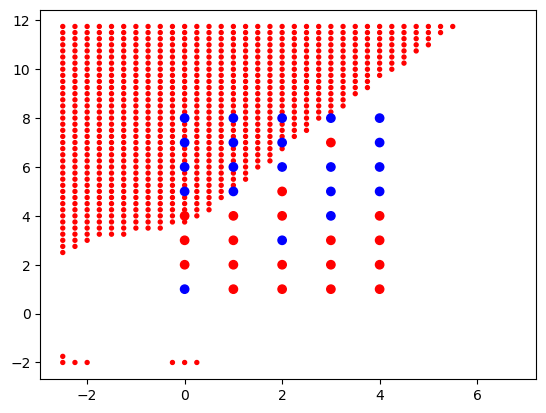

In [21]:
#PLOT FASE 2
dataset = ds.dataset
labels = ds.labels

with torch.no_grad():
    points = [[x/4, y/4, modello(torch.tensor([x/4*1.0,y/4*1.0]))] for x in range(-10,7*4) for y in range(-8,12*4)]
    colori = ['blue' if p[2][0] <= -0.6 else 'red' if p[2][0] >= 0.6 else 'white' for p in points]
    plt.scatter([p[0] for p in points], [p[1] for p in points], c = colori, s=8)
    plt.scatter([p[0] for p in dataset],[p[1] for p in dataset], c=['red' if i == 1 else 'blue' for i in labels])
    plt.show()

# RED -> y == 1 [NON DEVE ENTRARE]
# BLUE -> y == 0 [PUO ENTRARE]
# WHITE -> indecisione